In [1]:
import csv
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
window_size_ms = 200.
samples_per_window = 20

n = number of windows

`all_data`: (n, samples_per_window, 6) data (acc_x,acc_y,acc_z, gyro_x, gyro_y, gyro_z)

`has_touch`: (n,) array of +/-1 (bool for whether touch occured in this window)

`touch_loc`: (n,2) array of (x,y) touch locations

All times are adjusted so the first time in the dataset is 0.

In [339]:
dataset = "dataPixelRHandStandingRandom"
with open(dataset + ".csv") as f:
    # touch_x, touch_y, sensor, t, x, y, z = row
    csvreader = csv.reader(f)
    print(next(csvreader))
    csvf = list(csvreader)
print(csvf[0])
start_time = int(csvf[0][3])
print("Total time (s): ", (int(csvf[-1][3]) - start_time)/1000)

['-2.0', '-2.0', 'accelerometer', '1556846706990', '0.023820243775844574', '0.19748443365097046', '0.9562157988548279']
['-2.0', '-2.0', 'gyroscope', '1556846706994', '0.00787353515625', '0.108367919921875', '0.057403564453125']
Total time (s):  216.937


In [340]:
def normalize(arr):
    """Normalizes to [-1, 1]."""
    arr_min = np.min(arr, axis=0)
    arr_range = np.ptp(arr, axis=0)
    print("Min: ", arr_min)
    print("Range: ", arr_range)
    return (2.*(arr - arr_min) / arr_range) - 1

normalize(np.array([[100, 5, 1],[200, 6, 0],[150, 0,100]]))

Min:  [100   0   0]
Range:  [100   6 100]


array([[-1.        ,  0.66666667, -0.98      ],
       [ 1.        ,  1.        , -1.        ],
       [ 0.        , -1.        ,  1.        ]])

In [341]:
# Separate acc and gyro data
acc_data = np.array([[
    int(x[3]) - start_time, float(x[4]), float(x[5]), float(x[6])
] for x in csvf if x[2] == "accelerometer"])

acc_data[:, 1:] = normalize(acc_data[:, 1:])

gyro_data = np.array([[
    int(x[3]) - start_time, float(x[4]), float(x[5]), float(x[6])
] for x in csvf if x[2] == "gyroscope"])

gyro_data[:, 1:] = normalize(gyro_data[:, 1:])

end_time = max(acc_data[-1][0], gyro_data[-1][0])
num_windows = math.ceil((end_time / window_size_ms))
num_samples = num_windows * samples_per_window
print("Total time: ", end_time)
print("Num windows:", num_windows)
print("Num samples: ", num_samples)

Min:  [-0.88349003 -0.21655588 -0.98441917]
Range:  [1.30648491 1.15038292 2.63483113]
Min:  [-2.22851562 -3.23796082 -1.67318726]
Range:  [4.85092163 7.8894043  3.61878967]
Total time:  216937.0
Num windows: 1085
Num samples:  21700


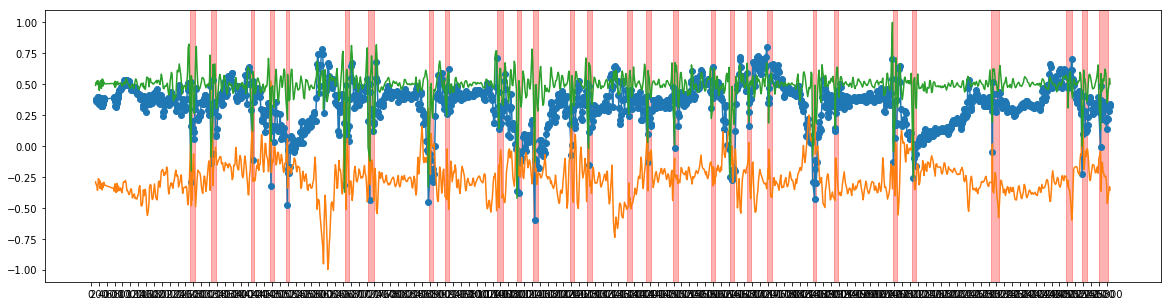

In [342]:
plt.figure(figsize=(20,5))

num_samples_to_view = 1500
plot_end_time = acc_data[num_samples_to_view - 1][0]
acc_data_t_ms = acc_data[:num_samples_to_view, 0]
plt.plot(acc_data_t_ms, acc_data[:num_samples_to_view, 1], marker="o")
plt.plot(acc_data_t_ms, acc_data[:num_samples_to_view, 2])
plt.plot(acc_data_t_ms, acc_data[:num_samples_to_view, 3])

presses = [int(x[3]) - start_time for x in csvf if x[2] == "press" if int(x[3]) - start_time < plot_end_time]
releases = [int(x[3]) - start_time for x in csvf if x[2] == "release" if int(x[3]) - start_time < plot_end_time]

presses = presses[:min(len(presses), len(releases))]

for i in range(len(presses)):
    plt.axvspan(presses[i], releases[i], alpha=0.3, color="r")
    
plt.xticks(np.arange(0, plot_end_time, step=200))
plt.show()

(3, 21700)
Done.


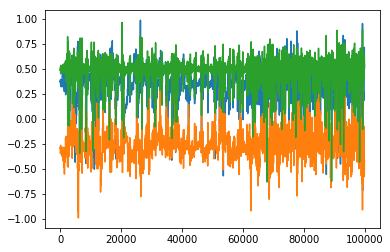

In [343]:
# Interpolate
interp_times = np.linspace(0, end_time, num=num_samples)

acc_data_ts = acc_data[:,0]
# Check times all increasing
assert(np.all(np.diff(acc_data_ts) > 0))
acc_data_interp = [
    np.interp(interp_times, acc_data_ts, acc_data[:,1]),
    np.interp(interp_times, acc_data_ts, acc_data[:,2]),
    np.interp(interp_times, acc_data_ts, acc_data[:,3]),
]

gyro_data_ts = gyro_data[:,0]
assert(np.all(np.diff(gyro_data_ts) > 0))
gyro_data_interp = [
    np.interp(interp_times, gyro_data_ts, gyro_data[:,1]),
    np.interp(interp_times, gyro_data_ts, gyro_data[:,2]),
    np.interp(interp_times, gyro_data_ts, gyro_data[:,3]),
]

num_samples_to_view = 10000
acc_data_interp = np.array(acc_data_interp)
print(acc_data_interp.shape)
plt.plot(interp_times[:num_samples_to_view], acc_data_interp[0, :num_samples_to_view])
plt.plot(interp_times[:num_samples_to_view], acc_data_interp[1, :num_samples_to_view])
plt.plot(interp_times[:num_samples_to_view], acc_data_interp[2, :num_samples_to_view])

all_data = np.concatenate((acc_data_interp, gyro_data_interp), axis=0).T
assert(all_data.shape == (num_samples, 6))
all_data = np.array(np.split(all_data, num_windows))
assert(all_data.shape == (num_windows, samples_per_window, 6))
print("Done.")

In [344]:
# Collect touch labels
# has_touch = 1 if there is a touch ONSET in that window
# TODO: might want to test this assumption

# (# presses, 3) array of (window #, touch_x, touch_y)
press_locs = np.array([[
    int(math.floor((int(x[3]) - start_time) / window_size_ms)), float(x[0]), float(x[1])
] for x in csvf if x[2] == "press"])

has_touch = -1 * np.ones((num_windows,))
touch_loc = -2 * np.ones((num_windows, 2))

has_touch[press_locs[:,0].astype(int)] = 1
touch_loc[press_locs[:,0].astype(int)] = press_locs[:,1:]
touch_loc = normalize(touch_loc)

assert(has_touch.shape == (num_windows,))
print("Number touch windows", np.sum(has_touch == 1))
print("Number no touch windows", np.sum(has_touch == -1))
assert(touch_loc.shape == (num_windows, 2))

Min:  [-2. -2.]
Range:  [345.42855835 622.8571167 ]
Number touch windows 427
Number no touch windows 658


/Users/jessy/.virtualenvs/cocosci/lib/python3.5/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


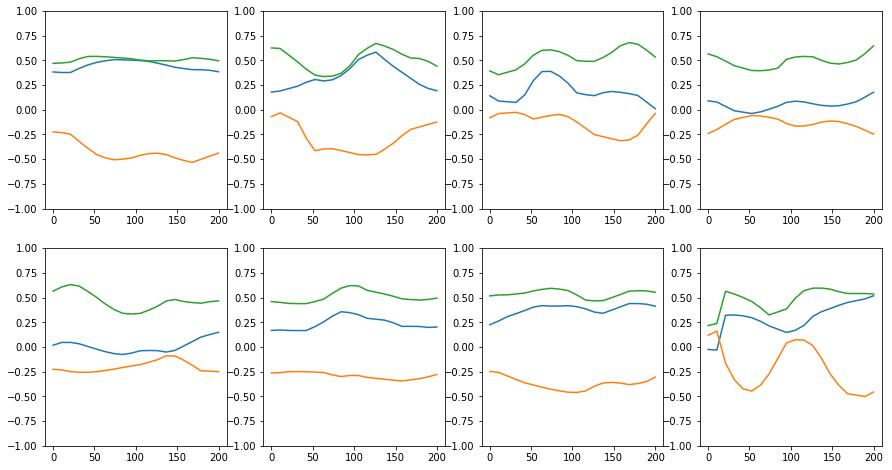

In [345]:
# Visualize touch / no touch windows
nrows = 2
ncols = 4
all_data = all_data.reshape((num_windows, samples_per_window, 6))

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 8))
axes = axes.reshape(-1)

count = 0
for i in range(50,len(has_touch)):
    if has_touch[i] == -1:
        if count == nrows * ncols: break
        axes[count].plot(np.linspace(0, window_size_ms, num=samples_per_window), all_data[i,:,0])
        axes[count].plot(np.linspace(0, window_size_ms, num=samples_per_window), all_data[i,:,1])
        axes[count].plot(np.linspace(0, window_size_ms, num=samples_per_window), all_data[i,:,2])
        axes[count].set_ylim(-1, 1)
        count += 1
        
fig.show()

/Users/jessy/.virtualenvs/cocosci/lib/python3.5/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


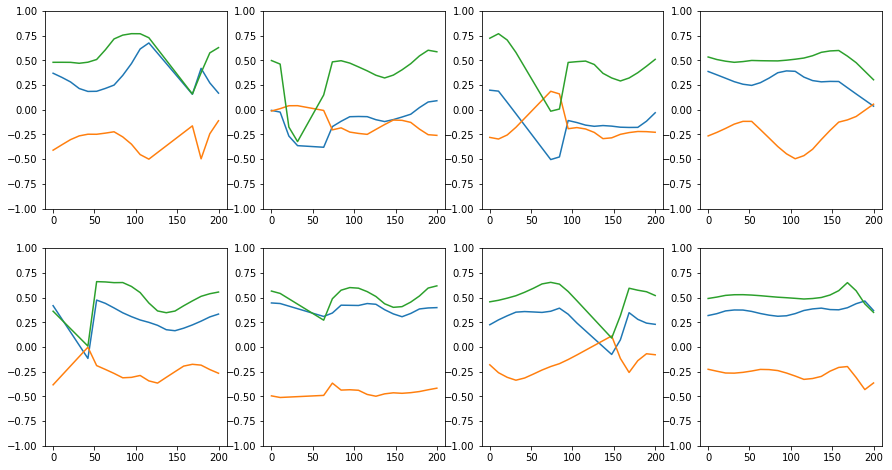

In [346]:
nrows = 2
ncols = 4
all_data = all_data.reshape((num_windows, samples_per_window, 6))

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 8))
axes = axes.reshape(-1)

count = 0
for i in range(50,len(has_touch)):
    if has_touch[i] == 1:
        if count == nrows * ncols: break
        axes[count].plot(np.linspace(0, window_size_ms, num=samples_per_window), all_data[i,:,0])
        axes[count].plot(np.linspace(0, window_size_ms, num=samples_per_window), all_data[i,:,1])
        axes[count].plot(np.linspace(0, window_size_ms, num=samples_per_window), all_data[i,:,2])
        axes[count].set_ylim(-1, 1)
        count += 1
        
fig.show()

In [347]:
# Flatten into one feature vector before saving
all_data = all_data.reshape(-1, samples_per_window * 6)

print("all_data: ", all_data.shape)
print("has_touch: ", has_touch.shape)
print("touch_loc: ", touch_loc.shape)
np.save("processed/{}_x.npy".format(dataset), all_data)
np.save("processed/{}_has_touch_y.npy".format(dataset), has_touch)
np.save("processed/{}_touch_loc_y.npy".format(dataset), touch_loc)

all_data:  (1085, 120)
has_touch:  (1085,)
touch_loc:  (1085, 2)


# ~ machine learning ~

In [170]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
from keras.optimizers import Adam
from keras import regularizers

In [171]:
X_balanced = np.load("processed/balanced_combined_X.npy")
has_touch_y_balanced = np.load("processed/balanced_combined_has_touch_y.npy")

In [226]:
def visualize_classes(X, y, class_lbl, title=""):
    nrows = 8
    ncols = 8
    X = X.reshape((-1, samples_per_window, 6))

    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 12))
    axes = axes.reshape(-1)

    count = 0
    for i in range(50,len(y)):
        if y[i] == class_lbl:
            if count == nrows * ncols: break
            axes[count].plot(np.linspace(0, window_size_ms, num=samples_per_window), X[i,:,0])
            axes[count].plot(np.linspace(0, window_size_ms, num=samples_per_window), X[i,:,1])
            axes[count].plot(np.linspace(0, window_size_ms, num=samples_per_window), X[i,:,2])
            axes[count].set_ylim(0, 1)
            axes[count].get_xaxis().set_visible(False)
            axes[count].get_yaxis().set_visible(False)
            count += 1
    fig.suptitle(title, fontsize=16)
    fig.show()

/Users/jessy/.virtualenvs/cocosci/lib/python3.5/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


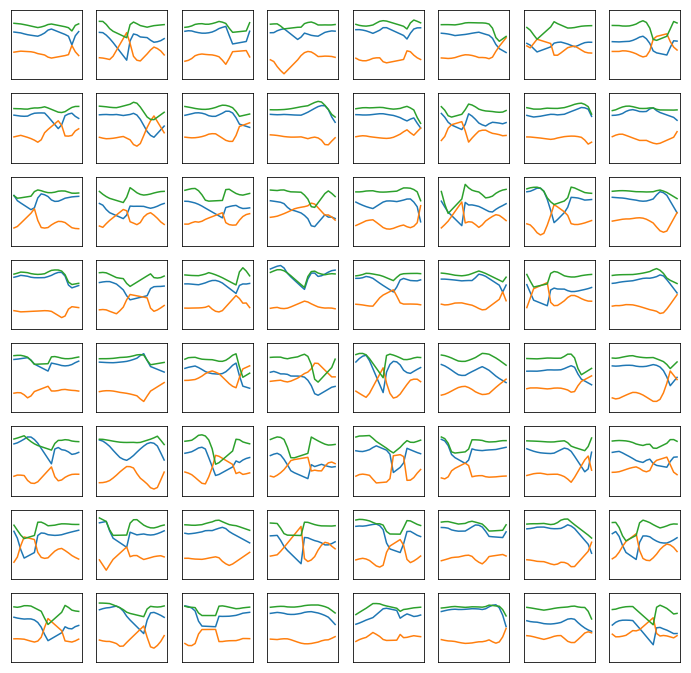

In [227]:
visualize_classes(X_balanced, has_touch_y_balanced, 1)

/Users/jessy/.virtualenvs/cocosci/lib/python3.5/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


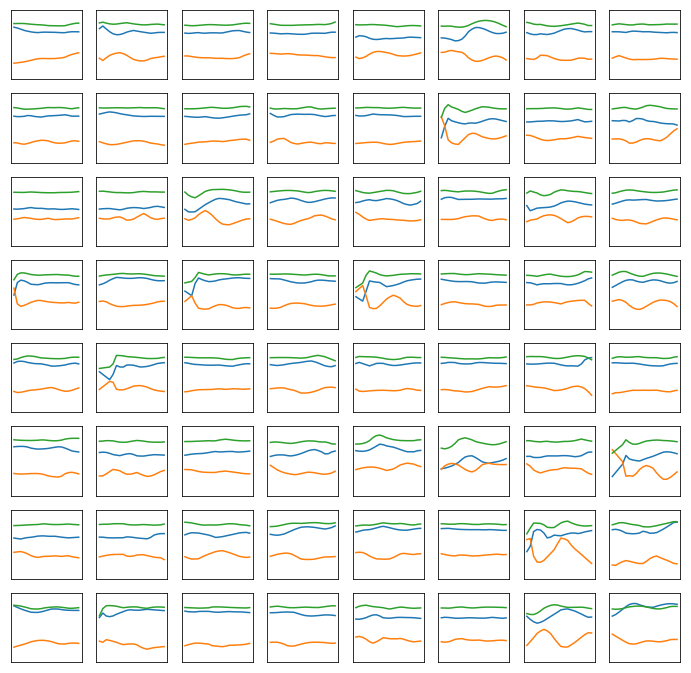

In [228]:
visualize_classes(X_balanced, has_touch_y_balanced, 0)

In [192]:
def build_model():
    model = Sequential()
    model.add(Dense(128, activation="relu", input_dim=(samples_per_window * 6)))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(64, activation="relu"))#, kernel_regularizer=regularizers.l2(0.003)))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer=Adam(lr=3e-4), metrics = ["accuracy"])
    return model

In [193]:
skf = StratifiedKFold(n_splits = 5, shuffle=True)

In [194]:
seed = 0

accs = []
histories = []

for train_idx, test_idx in skf.split(X_balanced, has_touch_y_balanced):
    x_train, x_test = X_balanced[train_idx], X_balanced[test_idx]
    y_train, y_test = has_touch_y_balanced[train_idx], has_touch_y_balanced[test_idx]
    
    model = build_model()
    
    history = model.fit(x_train, y_train, epochs=125, batch_size=20, validation_data=(x_test, y_test))
    _, acc = model.evaluate(x_test, y_test)
    print("ACCURACY: ", acc)
    accs.append(acc)
    histories.append(history)

Train on 1920 samples, validate on 482 samples
Epoch 1/125
1920/1920 [==============================] - 0s - loss: 0.5680 - acc: 0.7417 - val_loss: 0.5418 - val_acc: 0.7407
Epoch 2/125
1920/1920 [==============================] - 0s - loss: 0.5271 - acc: 0.7578 - val_loss: 0.5000 - val_acc: 0.7573
Epoch 3/125
1920/1920 [==============================] - 0s - loss: 0.4898 - acc: 0.7917 - val_loss: 0.4540 - val_acc: 0.7884
Epoch 4/125
1920/1920 [==============================] - 0s - loss: 0.4599 - acc: 0.8005 - val_loss: 0.4289 - val_acc: 0.8154
Epoch 5/125
1920/1920 [==============================] - 0s - loss: 0.4563 - acc: 0.8042 - val_loss: 0.4208 - val_acc: 0.8133
Epoch 6/125
1920/1920 [==============================] - 0s - loss: 0.4234 - acc: 0.8198 - val_loss: 0.4163 - val_acc: 0.8423
Epoch 7/125
1920/1920 [==============================] - 0s - loss: 0.4134 - acc: 0.8276 - val_loss: 0.3875 - val_acc: 0.8320
Epoch 8/125
1920/1920 [==============================] - 0s - loss: 0.4

1922/1922 [==============================] - 0s - loss: 0.4815 - acc: 0.7908 - val_loss: 0.4371 - val_acc: 0.8083
Epoch 4/125
1922/1922 [==============================] - 0s - loss: 0.4324 - acc: 0.8231 - val_loss: 0.4204 - val_acc: 0.8271
Epoch 5/125
1922/1922 [==============================] - 0s - loss: 0.4092 - acc: 0.8299 - val_loss: 0.4104 - val_acc: 0.8125
Epoch 6/125
1922/1922 [==============================] - 0s - loss: 0.4142 - acc: 0.8215 - val_loss: 0.4317 - val_acc: 0.8333
Epoch 7/125
1922/1922 [==============================] - 0s - loss: 0.4207 - acc: 0.8231 - val_loss: 0.3959 - val_acc: 0.8292
Epoch 8/125
1922/1922 [==============================] - 0s - loss: 0.3782 - acc: 0.8392 - val_loss: 0.3880 - val_acc: 0.8229
Epoch 9/125
1922/1922 [==============================] - 0s - loss: 0.3706 - acc: 0.8491 - val_loss: 0.4167 - val_acc: 0.8125
Epoch 10/125
1922/1922 [==============================] - 0s - loss: 0.3789 - acc: 0.8377 - val_loss: 0.3916 - val_acc: 0.8271
Epo

1922/1922 [==============================] - 0s - loss: 0.4296 - acc: 0.8195 - val_loss: 0.4415 - val_acc: 0.8104
Epoch 6/125
1922/1922 [==============================] - 0s - loss: 0.4204 - acc: 0.8278 - val_loss: 0.4907 - val_acc: 0.7938
Epoch 7/125
1922/1922 [==============================] - 0s - loss: 0.4358 - acc: 0.8153 - val_loss: 0.4275 - val_acc: 0.8250
Epoch 8/125
1922/1922 [==============================] - 0s - loss: 0.3965 - acc: 0.8371 - val_loss: 0.4157 - val_acc: 0.8333
Epoch 9/125
1922/1922 [==============================] - 0s - loss: 0.4136 - acc: 0.8252 - val_loss: 0.6114 - val_acc: 0.6667
Epoch 10/125
1922/1922 [==============================] - 0s - loss: 0.4291 - acc: 0.8075 - val_loss: 0.4782 - val_acc: 0.7958
Epoch 11/125
1922/1922 [==============================] - 0s - loss: 0.3930 - acc: 0.8377 - val_loss: 0.4165 - val_acc: 0.8271
Epoch 12/125
1922/1922 [==============================] - 0s - loss: 0.3847 - acc: 0.8403 - val_loss: 0.4074 - val_acc: 0.8292
E

1922/1922 [==============================] - 0s - loss: 0.4246 - acc: 0.8174 - val_loss: 0.3913 - val_acc: 0.8167
Epoch 8/125
1922/1922 [==============================] - 0s - loss: 0.4173 - acc: 0.8158 - val_loss: 0.4042 - val_acc: 0.8375
Epoch 9/125
1922/1922 [==============================] - 0s - loss: 0.4125 - acc: 0.8257 - val_loss: 0.4237 - val_acc: 0.8271
Epoch 10/125
1922/1922 [==============================] - 0s - loss: 0.4044 - acc: 0.8351 - val_loss: 0.3876 - val_acc: 0.8417
Epoch 11/125
1922/1922 [==============================] - 0s - loss: 0.3999 - acc: 0.8257 - val_loss: 0.3850 - val_acc: 0.8479
Epoch 12/125
1922/1922 [==============================] - 0s - loss: 0.3907 - acc: 0.8340 - val_loss: 0.3713 - val_acc: 0.8375
Epoch 13/125
1922/1922 [==============================] - 0s - loss: 0.3865 - acc: 0.8325 - val_loss: 0.3643 - val_acc: 0.8375
Epoch 14/125
1922/1922 [==============================] - 0s - loss: 0.3809 - acc: 0.8361 - val_loss: 0.3559 - val_acc: 0.8375

1922/1922 [==============================] - 0s - loss: 0.3927 - acc: 0.8304 - val_loss: 0.3974 - val_acc: 0.8354
Epoch 10/125
1922/1922 [==============================] - 0s - loss: 0.4036 - acc: 0.8257 - val_loss: 0.4043 - val_acc: 0.8333
Epoch 11/125
1922/1922 [==============================] - 0s - loss: 0.3823 - acc: 0.8413 - val_loss: 0.4786 - val_acc: 0.8062
Epoch 12/125
1922/1922 [==============================] - 0s - loss: 0.3742 - acc: 0.8418 - val_loss: 0.4090 - val_acc: 0.8229
Epoch 13/125
1922/1922 [==============================] - 0s - loss: 0.3886 - acc: 0.8319 - val_loss: 0.4577 - val_acc: 0.8188
Epoch 14/125
1922/1922 [==============================] - 0s - loss: 0.3990 - acc: 0.8257 - val_loss: 0.3849 - val_acc: 0.8333
Epoch 15/125
1922/1922 [==============================] - 0s - loss: 0.3661 - acc: 0.8418 - val_loss: 0.3968 - val_acc: 0.8292
Epoch 16/125
1922/1922 [==============================] - 0s - loss: 0.3851 - acc: 0.8299 - val_loss: 0.5218 - val_acc: 0.74

In [195]:
print(accs)
np.mean(accs)

[0.8734439834024896, 0.8604166666666667, 0.8645833333333334, 0.8895833333333333, 0.8791666666666667]


0.873438796680498

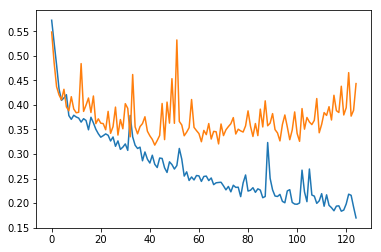

In [196]:
plt.plot(histories[1].history["loss"])
plt.plot(histories[1].history["val_loss"])

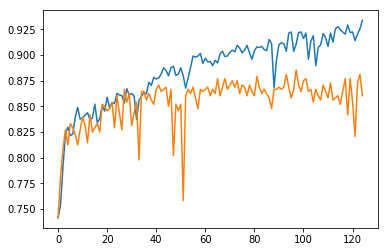

In [197]:
plt.plot(histories[1].history["acc"])
plt.plot(histories[1].history["val_acc"])

In [229]:
arr = np.array([[[100,2,0],[400,5,1]], [[50,2,3],[400,5,.5]]])
arr = arr.reshape(-1, 3)
print(arr)
print(arr.shape)

[[100.    2.    0. ]
 [400.    5.    1. ]
 [ 50.    2.    3. ]
 [400.    5.    0.5]]
(4, 3)


In [232]:
np.split(arr, 2)

[array([[100.,   2.,   0.],
        [400.,   5.,   1.]]), array([[ 50. ,   2. ,   3. ],
        [400. ,   5. ,   0.5]])]

In [208]:
arr.reshape((-1, 2, 3))

array([[[100. ,   2. ,   0. ],
        [400. ,   5. ,   1. ]],

       [[ 50. ,   2. ,   3. ],
        [400. ,   5. ,   0.5]]])